![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Plot an Ensemble of CMIP6 Climate Projections

### About

This notebook provides a practical introduction on how to access and process [CMIP6 global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview) data available in the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S). The workflow shows how to compute and visualize the output of an ensemble of models for the annual global average temperature between 1850 to 2100. You will use the `historical` experiment for the temporal period 1850 to 2014 and the three scenarios `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` for the period from 2015 to 2100.

For the sake of simplicity, and to facilitate data download, the tutorial will make use of some of the coarser resolution models that have a smaller data size. It is nevertheless only a choice for this exercise and not a recommendation (since ideally all models, including those with highest resolution, should be used). Many more models are available on the CDS, and when calculating an ensemble of models, it is best practice to use as many as possible for a more reliable output. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-Models,gridsandpressurelevels) a full list of models included in the CDS-CMIP6 dataset.

Learn [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections) more about CMIP6 global climate projections and the CMIP6 experiments in the CDS.


The notebook has the following outline:

1. Request data from the CDS programmatically with the CDS API
2. Unzip the downloaded data files
3. Load and prepare CMIP6 data for one model and one experiment
4. Load and prepare CMIP6 data for all models and experiments
5. Visualize CMIP6 annual global average temperature between 1850 to 2100

### Data

This notebook introduces you to [CMIP6 Global climate projections](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview). The datasets used in the notebook have the following specifications:

> **Data**: CMIP6 global climate projections of near-surface air temperature <br>
> **Experiments**: Historical, SSP1-2.6, SSP2-4.5, SSP5-8.5 <br>
> **Models**: 7 models from Germany, France, UK, Japan and Russia <br>
> **Temporal range**: Historical: 1850 - 2014. Scenarios: 2015 - 2100 <br>
> **Spatial coverage**: Global <br>
> **Format**: NetCDF, compressed into zip files

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=projections-cmip6.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/projections-cmip6.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Install CDS API via pip

In [ ]:
!pip install cdsapi

### Load libraries

In [7]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## Request data from the CDS programmatically with the CDS API

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [2]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [8]:
DATADIR = './'

The next step is then to request the data with the help of the CDS API. Below, we loop through multiple data requests. These include data for different models and scenarios. It is not possible to specify multiple models in one data request as their spatial resolution varies.

We will download monthly aggregated data. These are disseminated as netcdf files within a zip archive.

In order to loop through the various experiments and models in our data requests, we will specify them as Python 'lists' here:

In [9]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

In [10]:
models = ['hadgem3_gc31_ll', 'inm_cm5_0', 'inm_cm4_8', 'ipsl_cm6a_lr', 
          'miroc_es2l', 'mpi_esm1_2_lr', 'ukesm1_0_ll']

> **Note:** Note that these are a selection of the lightest models (in terms of data volume), to facilitate download for the sake of this exercise. There are many [more models available on the CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview).

Now we can download the data for each model and experiment sequentially. We will do this separately for the historical experiments and for the various future scenarios, given that they refer to two different time periods.

Before you run the cells below, the terms and conditions on the use of the data need to have been accepted in the CDS. You can view and accept these conditions by logging into the [CDS](http://cds.climate.copernicus.eu), searching for the dataset, then scrolling to the end of the `Download data` section.

> **Note:** For more information about data access through the Climate Data Store, please see the dedicated tutorial [here](./climate_data_store_intro.ipynb).

In [ ]:
# DOWNLOAD DATA FOR HISTORICAL PERIOD

c = cdsapi.Client(url=URL, key=KEY)

for j in models:
    c.retrieve(
        'projections-cmip6',
        {
            'format': 'zip',
            'temporal_resolution': 'monthly',
            'experiment': 'historical',
            'level': 'single_levels',
            'variable': 'near_surface_air_temperature',
            'model': f'{j}',
            'date': '1850-01-01/2014-12-31',
        },
        f'{DATADIR}cmip6_monthly_1850-2014_historical_{j}.zip')

In [ ]:
# DOWNLOAD DATA FOR FUTURE SCENARIOS

c = cdsapi.Client(url=URL, key=KEY)

for i in experiments[1:]:
    for j in models:
        c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'experiment': f'{i}',
                'level': 'single_levels',
                'variable': 'near_surface_air_temperature',
                'model': f'{j}',
                'date': '2015-01-01/2100-12-31',
            },
            f'{DATADIR}cmip6_monthly_2015-2100_{i}_{j}.zip')

## Unzip the downloaded data files

From the CDS, CMIP6 data are available as `NetCDF` files compressed into `zip` archives. For this reason, before we can load any data, we have to extract the files. Having downloaded the four experiments `historical`, `SSP1-2.6`, `SSP2-4.5` and `SSP5-8.5` as seperate zip files, we can use the functions from the `zipfile` Python package to extract their contents. For each zip file we first construct a `ZipFile()` object, then we apply the function `extractall()` to extract its content.

In [11]:
cmip6_zip_paths = glob(f'{DATADIR}*.zip')
for j in cmip6_zip_paths:
    with zipfile.ZipFile(j, 'r') as zip_ref:
        zip_ref.extractall(f'{DATADIR}')

#### Create a list of the extracted files

To facilitate batch processing later in the tutorial, here we create a list of the extracted NetCDF files:

In [12]:
cmip6_nc = list()
cmip6_nc_rel = glob(f'{DATADIR}tas*.nc')
for i in cmip6_nc_rel:
    cmip6_nc.append(os.path.basename(i))

We will briefly inspect this list by printing the first five elements, corresponding to the filenames of a sample of the extracted NetCDF files:

In [16]:
cmip6_nc[0:5]

['tas_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500216-20141216_v20190624.nc',
 'tas_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_201501-204912_v20200114.nc',
 'tas_Amon_HadGEM3-GC31-LL_ssp126_r1i1p1f3_gn_205001-210012_v20200114.nc',
 'tas_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_201501-204912_v20190908.nc',
 'tas_Amon_HadGEM3-GC31-LL_ssp245_r1i1p1f3_gn_205001-210012_v20190908.nc']

## Load and prepare CMIP6 data for one model and one experiment

Now that we have downloaded and extracted the data, we can prepare it in order to view a time series of the spread of annual global temperature for the model ensemble. These preparation steps include the following:

1. **Spatial aggregation**: to have a single global temperature value for each model/experiment dataset, and for each time step
2. **Temporal aggregation**: from monthly to yearly
3. **Conversion of temperature units** from degrees Kelvin to Celsius
4. **Addition of data dimensions** in preparation for the merging of datasets from different models and experiments

In this section we apply these steps to a single dataset from one model and one experiment. In the next section we merge data from all models/experiments in preparation for the final processing and plotting of the temperature time series.

#### Load and inspect data

We begin by loading the first of the NetCDF files in our list. We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read NetCDF files.

The result is a `xarray.Dataset` object with four dimensions: `bnds`, `lat`, `lon`, `time`, of which the dimension `bnds` is not callable.

In [17]:
ds = xr.open_dataset(f'{DATADIR}{cmip6_nc[0]}')
ds

<xarray.Dataset>
Dimensions:    (time: 1979, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1850-02-16 00:00:00 ... 2014-12-16 00:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-06-19T11:21:17Z
    ...                     ...
    title:                  HadGEM3-GC31-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/b6959414-d5ed-4cd9-a627-59238e52132d

By examining the data above, we can see from the temporal range (1850 to 2014) that it is from the `historical` experiment.

We see that the data dimensions have been given labelled coordinates of time, latitude and longitude. We can find more about the dataset from the `Attributes`, such information includes the model name, description of the variable (`long_name`), units, etc.

Some of this information we will need later, this includes the experiment and model IDs. We will save these into variables:

In [18]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

An `xarray.Dataset()` may contain arrays of multiple variables. We only have one variable in the dataset, which is near-surface air temperature, `tas`. Below we create an `xarray.DataArray()` object, which takes only one variable, but gives us more flexibility in processing.

In [19]:
da = ds['tas']

#### Spatial aggregation

The next step is to aggregate the temperature values spatially (i.e. average over the latitude and longitude dimensions) and compute the global monthly near-surface temperature.

A very important consideration however is that the gridded data cells do not all correspond to the same areas. The size covered by each data point varies as a function of latitude. We need to take this into account when averaging. One way to do this is to use the cosine of the latitude as a proxy for the varying sizes. 

This can be implemented by first calculating weights as a function of the cosine of the latitude, then applying these weights to the data array with the xarray function `weighted()`:

In [20]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

The next step is then to compute the mean across the latitude and longitude dimensions of the weighted data array with the function `mean()`. The result is a DataArray with one dimension (`time`).

In [21]:
da_agg = da_weighted.mean(['lat', 'lon'])

#### Temporal aggregation

We now aggregate the monthly global near-surface air temperature values to annual global near-surface air temperature values. This operation can be done in two steps: first, all the values for one specific year have to be grouped with the function `groupby()` and second, we can create the average of each group with the function `mean()`.

The result is a one-dimensional DataArray. Please note that this operation changes the name of the dimension from `time` to `year`.

In [22]:
da_yr = da_agg.groupby('time.year').mean()

#### Conversion from Kelvin to Celsius

The metadata of the original data (before it was stripped during the subsequent processing steps) tells us that the near-surface air temperature data values are in units of Kelvin. We will convert them to degrees Celsius by subtracting 273.15 from the data values. 

In [23]:
da_yr = da_yr - 273.15

#### Create additional data dimensions (to later combine data from multiple models & experiments)

Finally, we will create additional dimensions for the model and for the experiment. These we will label with the model and experiment name as taken from the metadata of the original data (see above). These will be useful when we repeat the processes above for all models and experiments, and combine them into one array.

In [24]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

## Load and prepare CMIP6 data for all models and experiments

To repeat the steps above for all models and all experiments, we will collect all of the commands we have used so far into a function, which we can then apply to a batch of files corresponding to the data from all models and experiments.

In [25]:
# Function to aggregate in geographical lat lon dimensions

def geog_agg(fn):
    ds = xr.open_dataset(f'{DATADIR}{fn}')
    exp = ds.attrs['experiment_id']
    mod = ds.attrs['source_id']
    da = ds['tas']
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    da_agg = da_weighted.mean(['lat', 'lon'])
    da_yr = da_agg.groupby('time.year').mean()
    da_yr = da_yr - 273.15
    da_yr = da_yr.assign_coords(model=mod)
    da_yr = da_yr.expand_dims('model')
    da_yr = da_yr.assign_coords(experiment=exp)
    da_yr = da_yr.expand_dims('experiment')
    da_yr.to_netcdf(path=f'{DATADIR}cmip6_agg_{exp}_{mod}_{str(da_yr.year[0].values)}.nc')

Now we can apply this function to all the extracted NetCDF files. The `try` and `except` clauses ensure that all NetCDF files are attempted, even if some fail to be processed. One reason why some may fail is if the data are labelled differently, e.g. the model *MCM-UA-1-0* has coordinates labelled as "*latitude*" and *longitude*". This differs from the suggested standard, and more commonly applied labels of "*lat*" and "*lon*". Any that fail will be recorded in a print statement, and these can be processed separately. See [here](https://confluence.ecmwf.int/display/CKB/CMIP6%3A+Global+climate+projections#CMIP6:Globalclimateprojections-QualitycontroloftheCDS-CMIP6subset) more details on the quality control of the CMIP6 datasets on the CDS.

In [26]:
for i in cmip6_nc:
    try:
        geog_agg(i)
    except: print(f'{i} failed')

In the absence of any print statements, we see that all files were successfully processed. 

We will now combine these processed files into one dataset for the final steps to create a visualisation of near-surface air temperature from the model ensemble.

If all files have the same coordinates, the function `xarray.open_mfdataset` will merge the data according to the same coordinates.

In [29]:
data_ds = xr.open_mfdataset(f'{DATADIR}cmip6_agg*.nc')

The dataset created by `xarray.open_mfdataset` is by default in the form of "lazy Dask arrays". 

Dask divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory. As opposed to eager evaluation, operations on Dask arrays are lazy, i.e. operations queue up a series of tasks mapped over blocks, and no computation is performed until you request values to be computed. For more details, see https://xarray.pydata.org/en/stable/user-guide/dask.html. 

To facilitate further processing we would need to convert these Dask arrays into in-memory "eager" arrays, which we can do by using the `load()` method: 

In [30]:
data_ds.load()

<xarray.Dataset>
Dimensions:     (year: 251, model: 7, experiment: 4)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    height      (model) float64 1.5 2.0 2.0 2.0 2.0 2.0 1.5
  * model       (model) object 'HadGEM3-GC31-LL' 'INM-CM4-8' ... 'UKESM1-0-LL'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    tas         (experiment, model, year) float64 13.75 13.62 ... 20.48 20.63

Finally, we create an Xarray DataArray object for the near-surface air temperature variable, 'tas':

In [31]:
data = data_ds['tas']

## Visualize the CMIP6 annual global average temperature between 1850 to 2100

We will now create a plot of the model ensemble of near-surface air temperature for the historical and future periods, according to the three selected scenarios.

#### Calculate quantiles for model ensemble

Rather than plotting the data from all models, we will instead view the range of values as given by quantiles, including the 10th (near to lower limit), the 50th (mid-range) and the 90th (near to upper limit) quantiles:

In [ ]:
data_90 = data.quantile(0.9, dim='model')
data_10 = data.quantile(0.1, dim='model')
data_50 = data.quantile(0.5, dim='model')

> **Note:** The warning message is due to the presence of NaN (Not a Number) data given that the historical and scenario datasets represent only parts (historical and future respectively) of the entire time series. As these two datasets have been merged, NaN values will exist (e.g. there will be no data for the historical experiment for the future period).

#### View time-series

Finally we will visualise this data in one time-series plot. We will use the matplotlib function `plot()`. The dimension `year` will be the x-axis and the near-surface air temperature values in degrees Celsius will be the y-axis. 

The plotting function below has four main parts:
* **Initiate the plot**: initiate a matplotlib plot with `plt.subplots()`
* **Plot the time-series**: plot the data for each experiment, including the historical experiment and three scenarios with the `plot()` function
* **Set axes limits, labels, title and legend**: Define title and axes labels, and add additional items to the plot, such as legend or gridlines
* **Save the figure**: Save the figure as a PNG file with the `matplotlib.pyplot.savefig()` function

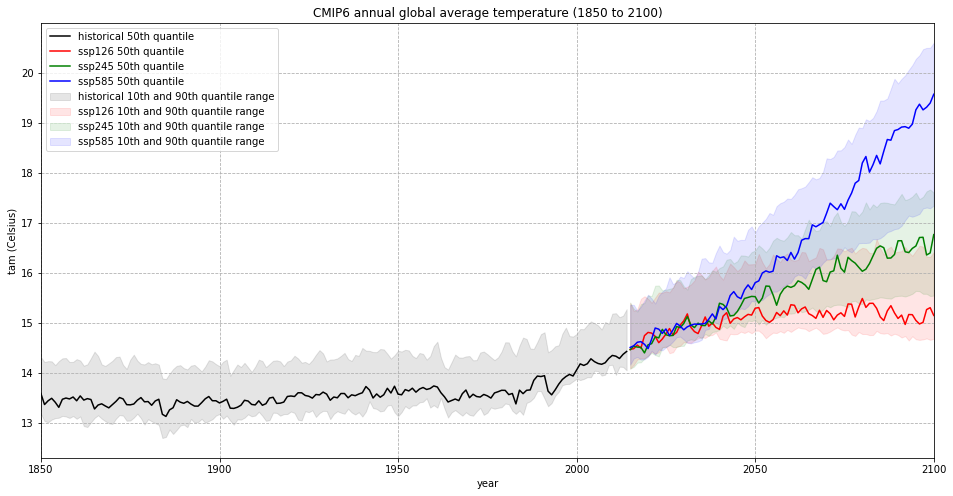

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 50th quantile')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 annual global average temperature (1850 to 2100)')
ax.set_ylabel('tam (Celsius)')
ax.set_xlabel('year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

The visualization of the `CMIP6 annual global average temperature (1850 to 2100)` above shows that the global average temperature was more or less stable in the pre-industrial phase, but steadily increases since the 1990s. It shows further that, depending on the SSP scenario, the course and increase of the global annual temperature differs. While for the best case `SSP1-2.6` scenario, the global annual temperature could stabilize around 15 degC, in the worst case `SSP5-8.5` scenario, the global annual temperature could increase to above 20 degC.

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>